In [ ]:
from google.colab import drive
drive.mount('/content/drive',)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

drive_path = '/content/drive/Shareddrives/Data Science Proyecto 2/DataSets'

df = pd.read_csv( drive_path + '/train.csv')
df.head()


,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,10,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,10,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,10,SR2021


In [ ]:
df['extent'] = df['extent'].astype(int) /10.0
df.head()

,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0.0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0.0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,1.0,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,1.0,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,1.0,SR2021


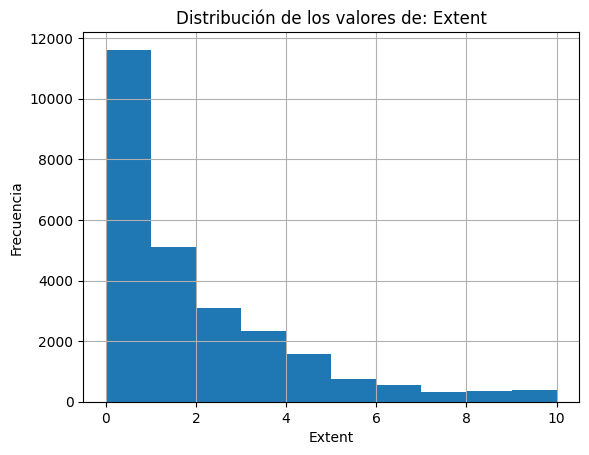

In [ ]:
import matplotlib.pyplot as plt

df['extent'].hist()
plt.title('Distribución de los valores de: Extent')
plt.xlabel('Extent')
plt.ylabel('Frecuencia')
plt.show()


# Modelos Clasificatorios

In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil


image_dir = drive_path + '/train'

In [ ]:

# destination = '/content/drive/Shareddrives/Data Science Proyecto 2/DataSets/train'
# for _, row in df.iterrows():
#   image_filename = row['filename']
#   class_label = int(row['extent'])
#   image_source_path = os.path.join(image_dir + '/', image_filename)
#   class_dir = os.path.join(destination, str(class_label))
#   image_destination_path = os.path.join(class_dir, image_filename)
#   if os.path.exists(image_source_path):
#         os.makedirs(class_dir, exist_ok=True)
#         shutil.copy(image_source_path, image_destination_path)
#   else:
#       print(f"Image not found: {image_source_path}")


In [ ]:
import pathlib

# Create a Path object for the directory
dir_path = pathlib.Path(image_dir)

# Use glob to list all files in the directory
files = list(dir_path.glob('*.jpg'))

# Count the number of files
file_count = len(files)

print("Number of files in the directory:", file_count)

Number of files in the directory: 17804


## Creando Datasets

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 15432 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 3857 files for validation.


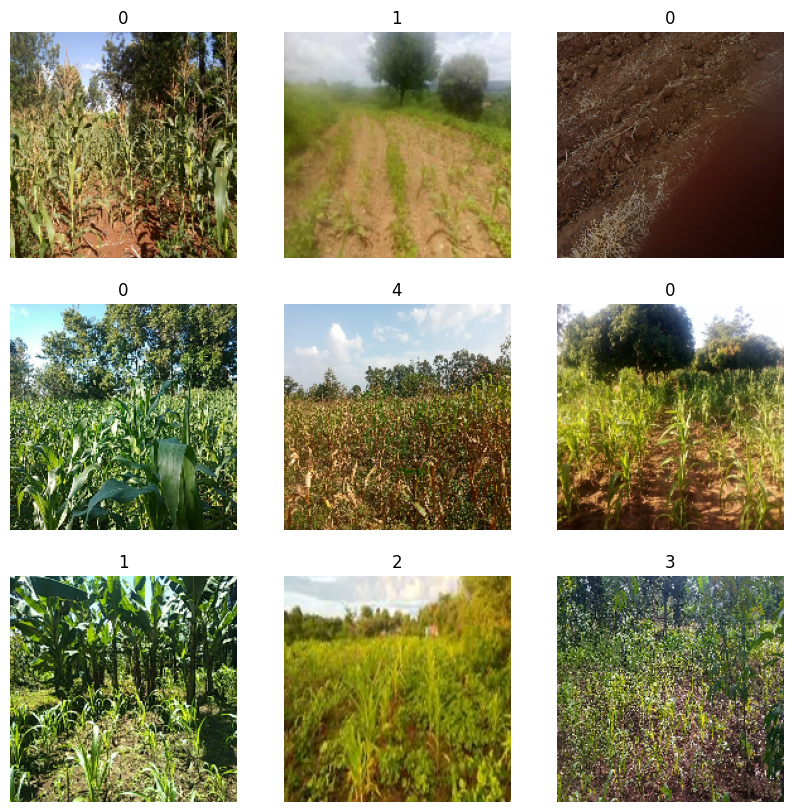

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creando un modelo

In [139]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Convertir valores RGB 0 - 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [140]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [141]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [143]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
483/483 [==============================] - 549s 1s/step - loss: 1.6393 - accuracy: 0.4370 - val_loss: 1.5936 - val_accuracy: 0.4309
Epoch 2/5
483/483 [==============================] - 504s 1s/step - loss: 1.5445 - accuracy: 0.4444 - val_loss: 1.6099 - val_accuracy: 0.4348
Epoch 3/5
483/483 [==============================] - 519s 1s/step - loss: 1.4961 - accuracy: 0.4546 - val_loss: 1.5547 - val_accuracy: 0.4353
Epoch 4/5
483/483 [==============================] - 515s 1s/step - loss: 1.4090 - accuracy: 0.4802 - val_loss: 1.5979 - val_accuracy: 0.4198
Epoch 5/5
483/483 [==============================] - 512s 1s/step - loss: 1.2248 - accuracy: 0.5447 - val_loss: 1.7019 - val_accuracy: 0.3938


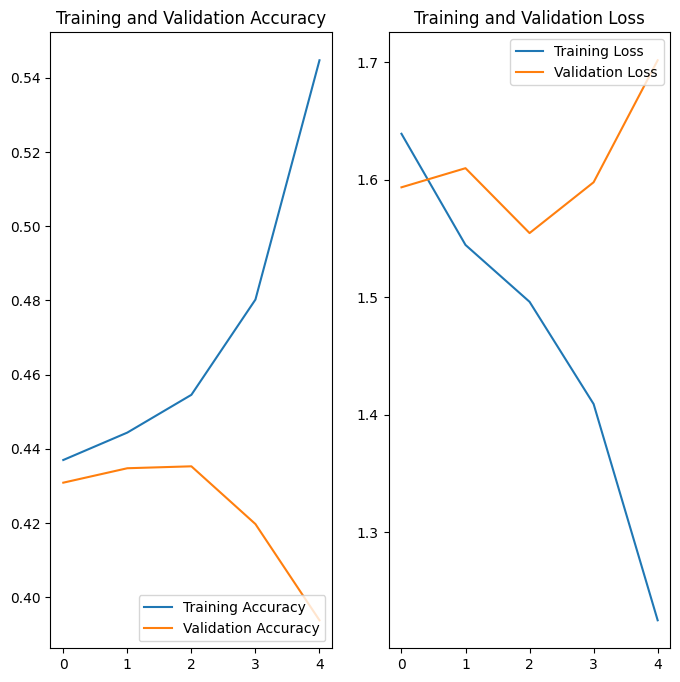

In [144]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()